(still in progress)

Load numpy arrays with patches from Seattle and San Francisco and create model based on that

In [ ]:
#install packages
!pip install patchify

In [ ]:
import os
import numpy as np

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


get the image chips created in previous script from drive

In [ ]:
#seattle data
image_array_seattle = np.load('link to image chips from 1 city')
park_array_seattle = np.load('link to park chips from 1 city')

In [ ]:
#san francisco data
image_array_san_francisco = np.load('link to image chips from 2 city')
park_array_san_francisco = np.load('link to park chips from 2 city')

In [ ]:
#check the image array shape seattle
print(image_array_seattle.shape)
print(park_array_seattle.shape)

(1326, 256, 256, 5)
(1326, 256, 256, 1)


In [ ]:
#check the image array shape san francisco
print(image_array_san_francisco.shape)
print(park_array_san_francisco.shape)

(600, 256, 256, 5)
(600, 256, 256, 1)


merge into one numpy array and check 

In [ ]:
#merge into one numpy array - two cities
image_dataset = np.concatenate((image_array_seattle, image_array_san_francisco), axis=0)
park_dataset = np.concatenate((park_array_seattle, park_array_san_francisco), axis=0)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


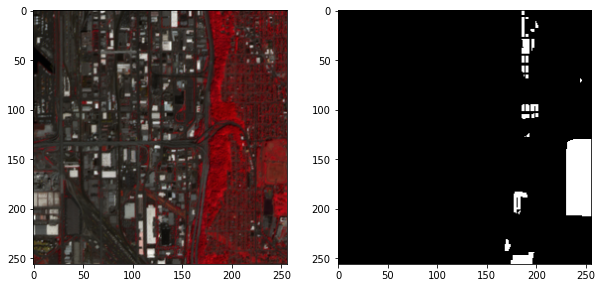

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

# plot satellite image with nir (more visible green areas then with true-color) 
plt.subplot(121)
img_r = image_dataset[image_number,:,:,3]
img_g = image_dataset[image_number,:,:,2]
img_b = image_dataset[image_number,:,:,1]
img_nir_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_nir_col)

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
print(image_dataset.max())
print(image_dataset.min())
print(np.unique(park_dataset))

1.0000002
0.0
[0. 1.]


In [ ]:
#maybe try balancing out the data, data augmentation, deleting chips that have less then 10% of park

prepering data for modelling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.20, random_state = 42) #changed the learning to 0.8

build model

In [ ]:
import cv2
import numpy as np

In [ ]:
_, rowSize, colSize, nBands = X_train.shape

In [ ]:
X_train.shape

(1540, 256, 256, 5)

In [ ]:
y_train.shape

(1540, 256, 256, 1)

In [ ]:
y_train.shape

(1540, 256, 256, 1)

In [ ]:
# define input shape
img_height = image_dataset.shape[1]
img_width  = image_dataset.shape[2]
img_bands = image_dataset.shape[3]

input_shape = (img_height, img_width, img_bands)
input_shape

(256, 256, 5)

In [ ]:
import logging
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import concatenate, Input, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
#code from https://github.com/jordancaraballo/nga-deep-learning/blob/master/scripts/core/unet.py

def unet_dropout(nclass=1, input_size=input_shape, weight_file=None,
                 maps=[64, 128, 256, 512, 1024]
                 ):
    """
    UNet network using dropout features.
    """
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(maps[0], (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(maps[0], (3, 3), activation='relu', padding='same')(c1)
    d2 = Dropout(0.2)(c1) #added by me - extra dropout
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(maps[1], (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(maps[1], (3, 3), activation='relu', padding='same')(c2)
    d2 = Dropout(0.2)(c2) #added by me - extra dropout
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(maps[2], (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(maps[2], (3, 3), activation='relu', padding='same')(c3)
    d3 = Dropout(0.2)(c3) #added by me - extra dropout
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(maps[3], (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(maps[3], (3, 3), activation='relu', padding='same')(c4)
    d4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(d4)

    # Squeeze
    c5 = Conv2D(maps[4], (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(maps[4], (3, 3), activation='relu', padding='same')(c5)
    d5 = Dropout(0.5)(c5)

    # Decoder - add dropout, think about different activation
    u6 = UpSampling2D(size=(2, 2))(d5)
    m6 = concatenate([d4, u6], axis=3)
    c6 = Conv2D(maps[3], (3, 3), activation='relu', padding='same')(m6)
    c6 = Conv2D(maps[3], (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    m7 = concatenate([c3, u7], axis=3)
    c7 = Conv2D(maps[2], (3, 3), activation='relu', padding='same')(m7)
    c7 = Conv2D(maps[2], (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    m8 = concatenate([c2, u8], axis=3)
    c8 = Conv2D(maps[1], (3, 3), activation='relu', padding='same')(m8)
    c8 = Conv2D(maps[1], (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    m9 = concatenate([c1, u9], axis=3)
    c9 = Conv2D(maps[0], (3, 3), activation='relu', padding='same')(m9)
    c9 = Conv2D(maps[0], (3, 3), activation='relu', padding='same')(c9)

    #actv = 'softmax' if more classes - uncomment to get softmax
    #if nclass == 1:
    actv = 'sigmoid'

    conv10 = Conv2D(nclass, (1, 1), activation=actv)(c9)
    model = Model(inputs=inputs, outputs=conv10, name="UNetDropout")

    if weight_file:
        model.load_weights(weight_file)
    return model

In [ ]:
model = unet_dropout()
model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNetDropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                       

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 16, verbose=1, epochs=10) #maybe try bigger batch size

Epoch 1/10
97/97 [==============================] - 51s 463ms/step - loss: 0.3405 - accuracy: 0.9048 - val_loss: 0.2803 - val_accuracy: 0.8939
Epoch 2/10
97/97 [==============================] - 42s 438ms/step - loss: 0.2338 - accuracy: 0.9109 - val_loss: 0.2484 - val_accuracy: 0.9073
Epoch 3/10
97/97 [==============================] - 43s 439ms/step - loss: 0.2013 - accuracy: 0.9225 - val_loss: 0.1937 - val_accuracy: 0.9255
Epoch 4/10
97/97 [==============================] - 43s 439ms/step - loss: 0.1777 - accuracy: 0.9315 - val_loss: 0.1806 - val_accuracy: 0.9303
Epoch 5/10
97/97 [==============================] - 43s 439ms/step - loss: 0.1601 - accuracy: 0.9396 - val_loss: 0.1491 - val_accuracy: 0.9425
Epoch 6/10
97/97 [==============================] - 43s 439ms/step - loss: 0.1327 - accuracy: 0.9512 - val_loss: 0.1284 - val_accuracy: 0.9535
Epoch 7/10
97/97 [==============================] - 43s 440ms/step - loss: 0.1139 - accuracy: 0.9589 - val_loss: 0.1116 - val_accuracy: 0.9604

In [ ]:
from tensorflow import keras
#model.save('/content/drive/MyDrive/1Utrecht_University/THESIS/Seattle_data/model-unet-10_seattle_san_francisco.h5') #save model to drive

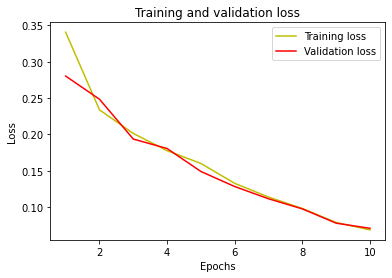

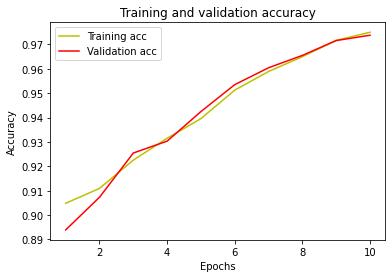

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#theres some overfitting there - work on that 

In [ ]:
#IoU
from tensorflow.keras.metrics import MeanIoU
#predict from model for all X_test
y_pred=model.predict(X_test)
# predictions are percentages, and we need 0 vs 1 so change to True/ False
y_pred_true_false = y_pred > 0.5
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_true_false, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.871505


to do - plot ground truth + predicted - use code down

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

# plot satellite image with nir (more visible green areas then with true-color) 
plt.subplot(121)
img_r = image_dataset[image_number,:,:,3]
img_g = image_dataset[image_number,:,:,2]
img_b = image_dataset[image_number,:,:,1]
img_nir_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_nir_col)

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
prediction.mean()

0.02044677734375

In [ ]:
len(prediction[0])

256

In [ ]:
prediction.shape

(256, 256)

test on Philedelphia in different script